# Feature selection

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.tree import DecisionTreeRegressor

We use tree-based feature selection and PCA for dimensionality reduction of our dataset

In [27]:
df = pd.read_csv('./data/new_train.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

# Find categorical variables
numerical = set(df.mean().index)
categorical = list(set(df.columns) - numerical) 

# Convert into categorical
for column in categorical:
    df[column] = df[column].astype('category')

df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,YrSold,SaleType,SaleCondition,SalePrice,Month,DJREI,Fannie,LaborForce,UnemplRate,Corn
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,2008,WD,Normal,208500,200802,244.57,5.534,49426.0,3.0,3.923512
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,2007,WD,Normal,181500,200705,334.04,6.131,47518.0,2.6,3.287290
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,2008,WD,Normal,223500,200809,241.88,6.208,49516.0,3.0,5.329546
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,2006,WD,Abnorml,140000,200602,275.15,6.123,47959.0,2.9,2.139554
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,2008,WD,Normal,250000,200812,145.63,5.140,49657.0,3.7,5.309256


## Tree-based feature selection

In [32]:
data = df.copy()
data[list(numerical)] = normalize(data[list(numerical)]) #normalize

X = data.copy().drop('SalePrice', axis=1)
y = data.copy()['SalePrice']

regression_tree = DecisionTreeRegressor(
 min_samples_split=10, min_samples_leaf=5,
  random_state=0)

one_hot_data = pd.get_dummies(df[categorical],drop_first=True)

regression_tree.fit(one_hot_data,y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

In [33]:
regression_tree.score(one_hot_data,y)

0.8708119686411153

In [48]:
importance = pd.DataFrame({'features':one_hot_data.columns, 'imp':regression_tree.feature_importances_}).\
                        sort_values('imp',ascending=False)

importance = importance.iloc[:20,]

<BarContainer object of 20 artists>

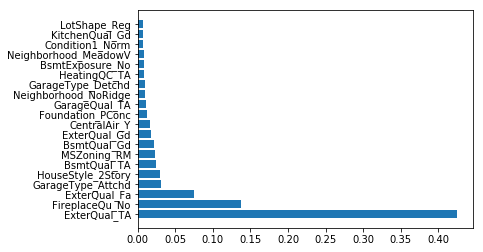

In [49]:
plt.barh(importance.features, importance.imp)